<a href="https://www.kaggle.com/code/subhamshome/mwd-randomforest?scriptVersionId=140480221" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# imports
import os
import re
import pandas as pd
from tqdm import tqdm
import numpy as np
from skimage import io, transform, color
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Exploratory Data Analysis (EDA)

In [2]:
# constants - data directory and image size
data_dir = '/kaggle/input/multiclass-weather-dataset/Multi-class Weather Dataset'
size_fact = 32 
image_size = (size_fact, size_fact, 3)

In [3]:
# create class labels and image counts
def count_images_in_subfolders(folder_path):
    class_labels = []
    image_counts = []

    if not os.path.exists(folder_path): # check for folder
        print("Folder does not exist.") 
        return class_labels, image_counts

    subfolders = [subfolder for subfolder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, subfolder))]

    for subfolder in subfolders:
        # check for both .jpg and .jpeg since there are some .jpeg files as well
        jpg_count = len([filename for filename in os.listdir(os.path.join(folder_path, subfolder)) if filename.lower().endswith(('.jpg', '.jpeg'))])
        class_labels.append(subfolder)
        image_counts.append(jpg_count)

    return class_labels, image_counts

# run for data directory
class_labels, image_counts = count_images_in_subfolders(data_dir)

print(class_labels)
print(image_counts)

['Cloudy', 'Sunrise', 'Rain', 'Shine']
[300, 357, 215, 253]


In [4]:
# rearrange for better representation and following the input data order (this step is optional)
def list_rearrange(listname):
    second_item = listname.pop(1)
    listname.append(second_item)

list_rearrange(class_labels)
list_rearrange(image_counts)

print(class_labels)
print(image_counts)

['Cloudy', 'Rain', 'Shine', 'Sunrise']
[300, 215, 253, 357]


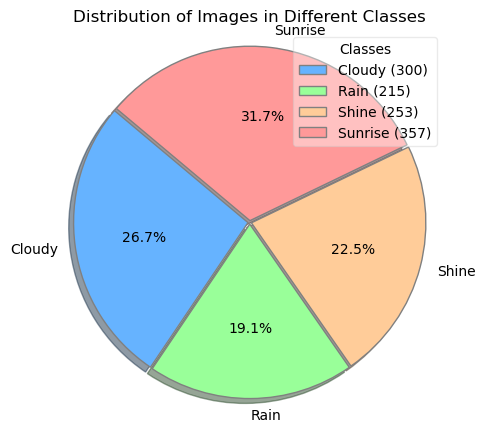

In [5]:
# pie chart depicting the distribution of classes across the data
colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ff9999']
explode = (0.01, 0.01, 0.01, 0.01)

plt.figure(figsize=(5, 5))
wedges, texts, autotexts = plt.pie(image_counts, labels=class_labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode, shadow=True, wedgeprops={'edgecolor': 'gray'})
plt.axis('equal')
plt.title('Distribution of Images in Different Classes')

for text, autotext in zip(texts, autotexts):
    angle = (autotext.get_position()[1] + text.get_position()[1]) / 2
    x = 0.5 * np.cos(np.deg2rad(angle))
    y = 0.5 * np.sin(np.deg2rad(angle))

legend_labels = [f"{label} ({count})" for label, count in zip(class_labels, image_counts)]
plt.legend(title="Classes", labels=legend_labels, loc="upper right", framealpha=0.4)

plt.show()

### Data Loading and Preprocessing

In [6]:
# initialising attributes and target variables
X = []
y = []

# walking through subfolders and creating the X and y datatables
for root, _, _ in os.walk(data_dir):
    for label in class_labels:
        label_dir = os.path.join(root, label)
        if not os.path.exists(label_dir):
            continue
        
        # check for both .jpg and .jpeg since there are some .jpeg files as well
        image_files = [f for f in os.listdir(label_dir) if f.lower().endswith(('.jpg', '.jpeg'))]

        for image_file in tqdm(image_files, desc=label, unit="image"):
            img_path = os.path.join(label_dir, image_file)
            img = io.imread(img_path)

            img_resized = transform.resize(img, image_size)

            if img_resized.shape[-1] == 4:
                img_resized = img_resized[:, :, :3]
            elif len(img_resized.shape) == 2:
                img_resized = color.gray2rgb(img_resized)

            X.append(img_resized.flatten())
            y.append(label)

Sunrise: 100%|██████████| 357/357 [03:28<00:00,  1.71image/s]


In [7]:
# convert to dataframe 
X = pd.DataFrame(X)
X = X.dropna(axis=1)

y = pd.DataFrame(y)

In [8]:
# visualising the datasets
X

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,0.712328,0.715405,0.736737,0.716215,0.716812,0.750346,0.758951,0.762047,0.781891,0.771589,...,0.576344,0.535893,0.561735,0.592869,0.551842,0.576275,0.610885,0.541993,0.567778,0.613125
1,0.479597,0.560659,0.665624,0.473764,0.570218,0.685725,0.454786,0.581035,0.702581,0.434411,...,0.228549,0.083011,0.147127,0.217034,0.087310,0.139465,0.206681,0.085701,0.136064,0.202892
2,0.261868,0.329653,0.371975,0.323765,0.379521,0.411975,0.369493,0.427881,0.451056,0.338138,...,0.016222,0.026326,0.034170,0.022405,0.018396,0.026239,0.014474,0.015154,0.022997,0.011232
3,0.779708,0.783500,0.803178,0.793963,0.793779,0.815620,0.782229,0.779186,0.804252,0.760654,...,0.362423,0.317244,0.336852,0.352441,0.305319,0.325133,0.340832,0.292630,0.318212,0.332155
4,0.448711,0.558386,0.642834,0.485046,0.590266,0.666225,0.473818,0.576157,0.665450,0.478132,...,0.033870,0.005878,0.009054,0.003442,0.010081,0.012280,0.011766,0.017431,0.022226,0.024695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,0.460583,0.472335,0.491943,0.490005,0.499825,0.519433,0.539383,0.543749,0.563410,0.563436,...,0.070676,0.109455,0.087761,0.058412,0.091839,0.077767,0.057423,0.143273,0.120706,0.100826
1121,0.263098,0.469978,0.351052,0.274964,0.482654,0.358454,0.281336,0.491099,0.351727,0.297414,...,0.020912,0.899242,0.487396,0.027610,0.881765,0.467924,0.026582,0.873502,0.457611,0.024783
1122,0.262434,0.303782,0.370812,0.255502,0.301075,0.363833,0.262424,0.306614,0.369107,0.265653,...,0.077095,0.080764,0.080870,0.077851,0.079380,0.079559,0.077684,0.078498,0.078558,0.073955
1123,0.077677,0.117434,0.277444,0.082217,0.129219,0.296944,0.094050,0.143090,0.314846,0.094810,...,0.030106,0.072460,0.070696,0.029518,0.094123,0.089367,0.033455,0.066377,0.080293,0.025895


In [9]:
y

,0
0,Cloudy
1,Cloudy
2,Cloudy
3,Cloudy
4,Cloudy
...,...
1120,Sunrise
1121,Sunrise
1122,Sunrise
1123,Sunrise


### Data Splitting

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

# data split outputs
print("Total images for Training:", len(y_train))
print("Total images for Testing:", len(y_test))

Total images for Training: 900
Total images for Testing: 225


### Classification using Random Forest Classifier

In [11]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

y_train = y_train.values.ravel() # to get targets into correct format

rf_model.fit(X_train, y_train)
print("Training done.")

y_pred_rf = rf_model.predict(X_test)
print("Prediction done.")

Training done.
Prediction done.


### Performance Evaluation

In [12]:
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, average='weighted')
recall = recall_score(y_test, y_pred_rf, average='weighted')
f1 = f1_score(y_test, y_pred_rf, average='weighted')

print(f"Accuracy: {accuracy} \n\nPrecision: {precision} \nRecall: {recall} \nF1-Score: {f1}")

Accuracy: 0.8711111111111111 

Precision: 0.8719088730270783 
Recall: 0.8711111111111111 
F1-Score: 0.8705888266653147


### Confusion Matrix

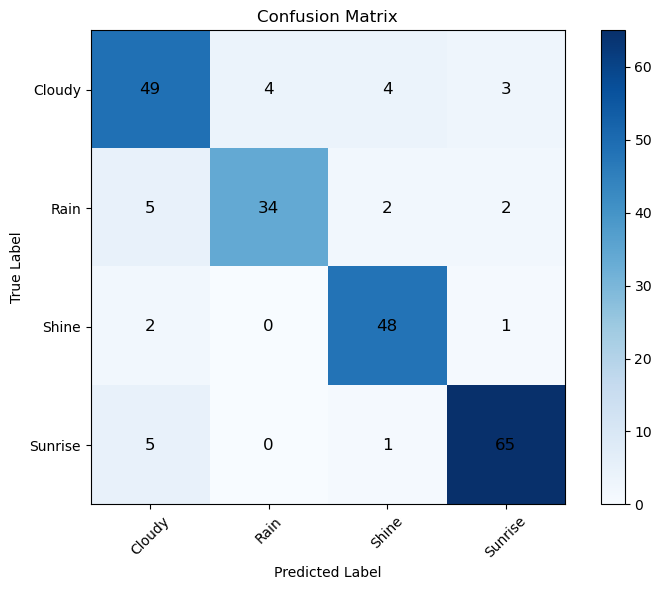

In [13]:
conf_matrix = confusion_matrix(y_test, y_pred_rf, labels=class_labels)

plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix")
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black', fontsize=12)

plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()